# How to Access the "Giovanni in the Cloud: Time Series" Service Using Python

### Date Authored: 03-04-2024

### Timing

Exercise: 5 minutes

### Overview

This notebook demonstrates how to access the "Giovanni in the Cloud: Time Series" service via Python. It demonstrates how to retrieve a token from the service, set parameters including bounding boxes and duration, and plot a sample time series using `matplotlib`. Here, the sample time series plotted is 3-hourly [GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.1 (GLDAS_NOAH025_3H)](https://disc.gsfc.nasa.gov/datasets/GLDAS_NOAH025_3H_2.1/summary?keywords=GLDAS_NOAH025_3H_2_1_Tair_f_inst) temperature over a grid in Benton Township, South Dakota, between January and October 2000-2020.

### Prerequisites

This notebook was written using Python 3.10, and requires:
- Valid [Earthdata Login credentials](https://urs.earthdata.nasa.gov), and the generation of [Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files) including the <code>.netrc</code> and `.dodsrc` files.
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)


## 1. Import Libraries

In [1]:
import netrc
import requests
from requests.auth import HTTPBasicAuth
import os
import io
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Store the Token Endpoint URLs 

In [2]:
# Setup the signin and time series URLs
signin_url = "https://api.giovanni.earthdata.nasa.gov/signin"
time_series_url = "https://api.giovanni.earthdata.nasa.gov/timeseries"


## 3. Store Parameters

Look at 20 years of 3-hourly temperature data over 45.125N,98.125W, which is in Benton Township, South Dakota.

In [3]:
lat = 45.125
lon = -98.125
time_start = "2000-01-01T03:00:00"
time_end = "2020-09-30T21:00:00"
data = "GLDAS_NOAH025_3H_2_1_Tair_f_inst"

## 4. Retrieve Token

We will use the Earthdata Login credentials stored in our local `netrc` file to retrieve a token. The token is valid for 24 hours, so we can actually use the same token repeatedly.

To create a `.netrc` file, please use this guide: [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?keywords=prerequisite&title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)

In [4]:
token = requests.get(signin_url, auth=HTTPBasicAuth(netrc.netrc().hosts['urs.earthdata.nasa.gov'][0], 
                                                    netrc.netrc().hosts['urs.earthdata.nasa.gov'][2]),
                     allow_redirects=True).text.replace('"','')


## 5. Define a Function That Calls the Time Series Service

In [5]:
def call_time_series(lat,lon,time_start,time_end,data):
    """
    INPUTS:
    lat - latitude
    lon - longitude
    time_start - start of time series in YYYY-MM-DDThh:mm:ss format (UTC)
    end_time - end of the time series in YYYY-MM-DDThh:mm:ss format (UTC)
    data - name of the data parameter for the time series
    
    OUTPUT:
    time series csv output string
    """
    query_parameters = {
        "data":data,
        "location":"[{},{}]".format(lat,lon),
        "time":"{}/{}".format(time_start,time_end)
    }
    headers = {"authorizationtoken":token}
    response=requests.get(time_series_url,params=query_parameters,headers=headers)
    return response.text


## 6. Define a Function That Parses the Response From the Time Series Service

This will return the headers from the CSV as a Python dictionary, and the values formatted as a Pandas dataframe.

In [6]:
def parse_csv(ts):
    """
    INPUTS:
    ts - time series output of the time series service
    
    OUTPUTS:
    headers,df - the headers from the CSV as a dict and the values in a pandas dataframe
    """
    with io.StringIO(ts) as f:
        # the first 13 rows are header
        headers = {}
        for i in range(13):
            line = f.readline()
            key,value = line.split(",")
            headers[key] = value.strip()

        # Read the csv proper
        df = pandas.read_csv(
            f,
            header=1,
            names=("Timestamp",headers["param_name"]),
            converters={"Timestamp":pandas.Timestamp}
        )

    return headers, df

## 7. Call the Time Series Service

The response will be stored in a variable called `df`.

In [7]:
%%time
ts = call_time_series(lat,lon,time_start,time_end,data)


CPU times: user 16.9 ms, sys: 7 ms, total: 23.9 ms
Wall time: 13.7 s


## 8. Parse the output

In [8]:
headers,df = parse_csv(ts)
print(df.head())

            Timestamp  Near surface air temperature
0 2000-01-01 03:00:00                       274.663
1 2000-01-01 06:00:00                       271.324
2 2000-01-01 09:00:00                       269.039
3 2000-01-01 12:00:00                       268.380
4 2000-01-01 15:00:00                       267.331


## 9. Plot Results

Text(0.5, 1.0, 'GLDAS_NOAH025_3H_2_1_Tair_f_inst at [45.125,-98.125]')

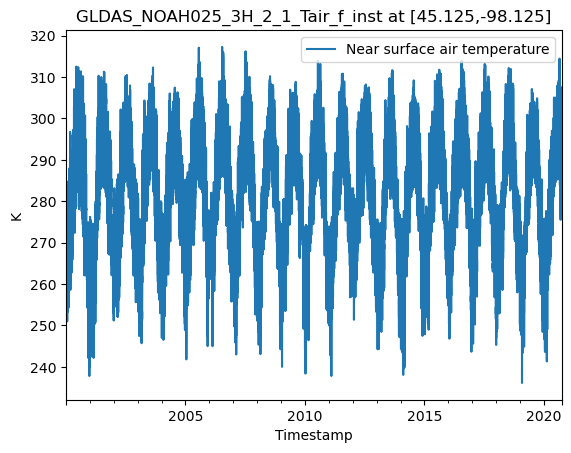

In [10]:
ax = plt.gca()
df.plot(x="Timestamp",y=headers["param_name"],ax=ax)
ax.set_ylabel(headers["unit"])
ax.set_title("{} at [{},{}]".format(data,headers["lat"],headers["lon"]))